# Проект: Исследовательский анализ данных сервиса Яндекс Афиша

- Автор: Владимир Добров
- Дата: 2025-08-01

## Цель и задача исследования  

**Цель:**   
Провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.  

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - Анализ распределения заказов по сегментам и их сезонные изменения;
    - Осенняя активность пользователейОсенняя активность пользователей;
    - Популярные события и партнёры.
4. Статистический анализ данных
5. Сформулировать выводы по проведённому анализу.

## Описание данных

Данные состоят из трёх датасетов:  

#### Таблица `final_tickets_orders_df.csv`
Содержит информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных:  

- order_id — уникальный идентификатор заказа.
- user_id — уникальный идентификатор пользователя.
- created_dt_msk — дата создания заказа (московское время).
- created_ts_msk — дата и время создания заказа (московское время).
- event_id — идентификатор мероприятия из таблицы events.
- cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- age_limit — возрастное ограничение мероприятия.
- currency_code — валюта оплаты, например rub для российских рублей.
- device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- revenue — выручка от заказа.
- service_name — название билетного оператора.
- tickets_count — количество купленных билетов.
- total — общая сумма заказа.
- days_since_prev - количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

#### Таблица `final_tickets_events_df.csv`
Содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия:  

- event_id — уникальный идентификатор мероприятия.
- event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- event_type_description — описание типа мероприятия.
- event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
- organizers — организаторы мероприятия.
- region_name — название региона.
- city_name — название города.
- venue_id — уникальный идентификатор площадки.
- venue_name — название площадки.
- venue_address — адрес площадки.

#### Таблица `final_tickets_tenge_df.csv`
Содержит информацию о с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге:  

- nominal — номинал (100 тенге).
- data — дата.
- curs — курс тенге к рублю.
- cdx — обозначение валюты (kzt).

### 1. Загрузка данных и знакомство с их содержимым

In [1]:
# Устанавливаем библиотеку визуализации данных
!pip install matplotlib-venn

In [2]:
# Импортируем библиотеки
import pandas as pd

import numpy as np
# import datetime

from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

# Импортируем библиотеки для визуализации данных
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [3]:
# Выгружаем и сохраняем в датафрейм данные
PATH = "https://code.s3.yandex.net/datasets/"
orders = pd.read_csv(PATH + "final_tickets_orders_df.csv" )
events = pd.read_csv(PATH + "final_tickets_events_df.csv")
exchange = pd.read_csv(PATH + "final_tickets_tenge_df.csv")

# Выводим на экран первые пять строк датафрейма
display(orders.head(5))
display(events.head(5))
display(exchange.head(5))

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [4]:
# Выводим информацию о датафреймах
orders.info()
print()
events.info()
print()
exchange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Выводы:
- Первичноый анализ полноты данных показывает, что данные достаточно высокого качества. Присутствуют 30 неявных дубликатов и пропущенные 7.5% данных в колонке с количеством дней с предыдущей покупки. Также колоноки с датами необходимо перевести из формата object в datetime. В целом полнона и корректность данных достаточна для анализа.

### 2. Предобработка данных и подготовка их к исследованию

In [5]:
# Объеденим данные в единый датафрейм df_all
df_all = orders.merge(events, on='event_id').merge(exchange, left_on='created_dt_msk', right_on='data', how='left')

#### 2.1 Проверка данных на пропуски

In [6]:
# Посчитаем процент пропусков в каждом столбце
print(df_all.isna().mean().round(3)*100)

order_id                  0.0
user_id                   0.0
created_dt_msk            0.0
created_ts_msk            0.0
event_id                  0.0
cinema_circuit            0.0
age_limit                 0.0
currency_code             0.0
device_type_canonical     0.0
revenue                   0.0
service_name              0.0
tickets_count             0.0
total                     0.0
days_since_prev           7.5
event_name                0.0
event_type_description    0.0
event_type_main           0.0
organizers                0.0
region_name               0.0
city_name                 0.0
city_id                   0.0
venue_id                  0.0
venue_name                0.0
venue_address             0.0
data                      0.0
nominal                   0.0
curs                      0.0
cdx                       0.0
dtype: float64


Вывод:
- Пропуски 7.5% присутствуют только столбца `days_since_prev`. Остальные данные не содержат пропусков. Наличие данных пропусков не являются существенным и не помешают объективному исследованию 

#### 2.2 Изучим значения в ключевых столбцах для категориальных значений

In [7]:
# Изучим, какие категории присутствуют в данных.
col_category =['device_type_canonical', 'currency_code', 'service_name', 'event_type_description', 'event_type_main']

for col in col_category:
    print('\n'.join(df_all[col].sort_values().unique().tolist()))
    print()

desktop
mobile

kzt
rub

Crazy ticket!
Show_ticket
Билет по телефону
Билеты без проблем
Билеты в интернете
Билеты в руки
Быстробилет
Быстрый кассир
Весь в билетах
Восьмёрка
Вперёд!
Выступления.ру
Городской дом культуры
Дом культуры
Дырокол
За билетом!
Зе Бест!
КарандашРУ
Кино билет
Край билетов
Лимоны
Лови билет!
Лучшие билеты
Мир касс
Мой билет
Облачко
Прачечная
Радио ticket
Реестр
Росбилет
Тебе билет!
Телебилет
Тех билет
Цвет и билет
Шоу начинается!
Яблоко

балет
выставка
концерт
кукольный спектакль
музыкальный спектакль
мюзикл
опера
оперетта
подарок
рок-мюзикл
снегурочка
событие
спектакль
спорт
спортивное мероприятие
фестиваль
цирковое шоу
шоу
экскурсия
ёлка

выставки
другое
концерты
спорт
стендап
театр
ёлки



#### 2.3 Изучим значения в ключевых столбцах для количественных значений

In [8]:
# Разделим анализ по валютам заказа
# для российского рубля
df_rub = df_all[df_all['currency_code']=='rub']
# для казахстанского тэнге
df_kzt = df_all[df_all['currency_code']=='kzt']

#### - для валюты заказа - rub

In [9]:
# Изучаем статистические показатели количественных значений колонок 
col_for_analiz = ['revenue', 'tickets_count']

for col in col_for_analiz:
    print(f'Статистические показатели столбца - {col} - rub:')
    print(df_rub[col].describe().astype('int'))
    print()

Статистические показатели столбца - revenue - rub:
count    285542
mean        548
std         871
min         -90
25%         114
50%         346
75%         793
max       81174
Name: revenue, dtype: int32

Статистические показатели столбца - tickets_count - rub:
count    285542
mean          2
std           1
min           1
25%           2
50%           3
75%           4
max          57
Name: tickets_count, dtype: int32



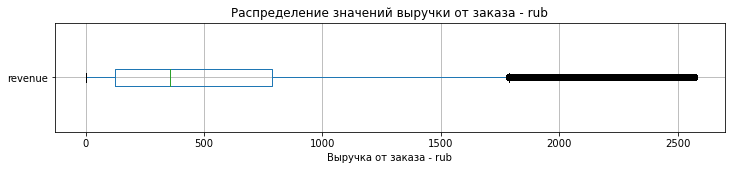

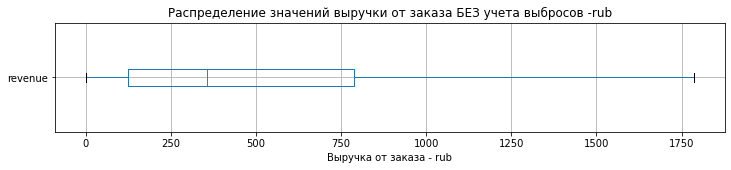

In [10]:
# Для визуализации уберём экстемальные выбросы 1% слева и справа колонки revenue
Q1 = df_rub['revenue'].quantile(0.01)
Q3 = df_rub['revenue'].quantile(0.99)

# Строим диаграмму размаха значений в столбце revenue
df_quantile_rub = df_rub[(df_rub['revenue'] > Q1) & (df_rub['revenue'] < Q3)]
df_quantile_rub.boxplot(column="revenue",
                    figsize=(12, 2),
                    vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений выручки от заказа - rub')
plt.xlabel('Выручка от заказа - rub') 

# Выводим график
plt.show()

df_quantile_rub.boxplot(column="revenue",
                    figsize=(12, 2),
                    showfliers=False,
                    vert=False)
plt.title('Распределение значений выручки от заказа БЕЗ учета выбросов -rub')
plt.xlabel('Выручка от заказа - rub') 
plt.show()

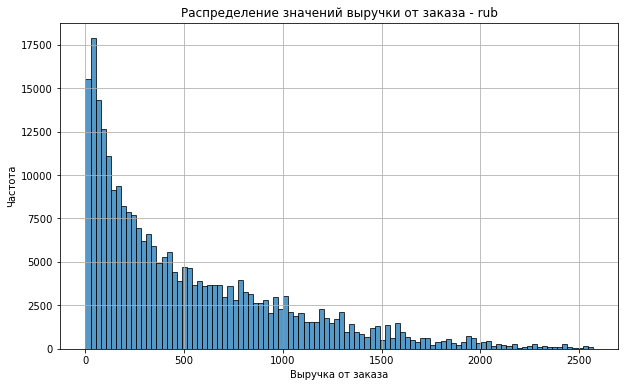

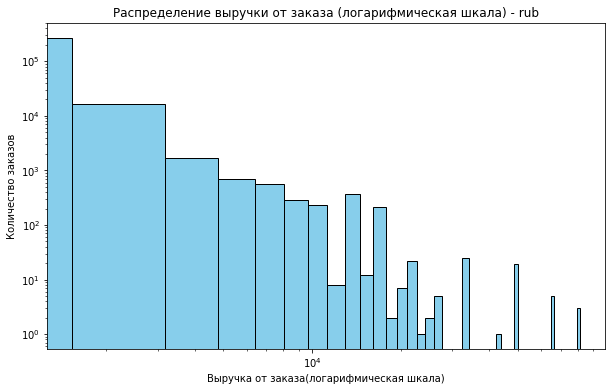

In [11]:
# Строим гистограмму распределения значений
df_quantile_rub['revenue'].plot(
                kind='hist', # гистограмма
                bins=100, # количество корзин
                figsize=(10, 6),
                alpha=0.75,
                edgecolor='black')


# Настраиваем оформление графика
plt.title('Распределение значений выручки от заказа - rub')
plt.xlabel('Выручка от заказа')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

# Строим гистограмму с логарифмической шкалой
plt.figure(figsize=(10, 6))
plt.hist(df_all['revenue'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.xscale('log')  # Логарифмическая шкала по оси X
plt.xlabel('Выручка от заказа(логарифмическая шкала)')
plt.ylabel('Количество заказов')
plt.title('Распределение выручки от заказа (логарифмическая шкала) - rub')
plt.show()


#### - для валюты заказа - kzt

In [12]:
# Изучаем статистические показатели количественных значений колонок 
col_for_analiz = ['revenue', 'tickets_count']

for col in col_for_analiz:
    print(f'Статистические показатели столбца - {col} - kzt:')
    print(df_kzt[col].describe().astype('int'))
    print()

Статистические показатели столбца - revenue - kzt:
count     5069
mean      4995
std       4916
min          0
25%        518
50%       3698
75%       7397
max      26425
Name: revenue, dtype: int32

Статистические показатели столбца - tickets_count - kzt:
count    5069
mean        2
std         1
min         1
25%         2
50%         3
75%         4
max         6
Name: tickets_count, dtype: int32



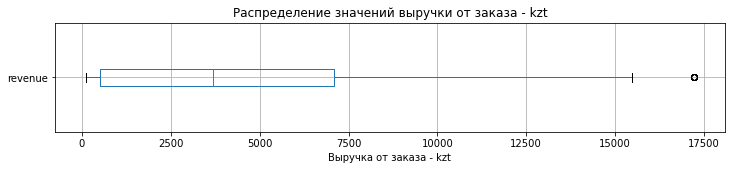

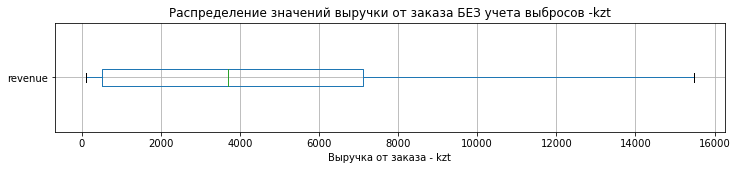

In [13]:
# Для визуализации уберём экстемальные выбросы 1% слева и справа колонки revenue
Q1 = df_kzt['revenue'].quantile(0.01)
Q3 = df_kzt['revenue'].quantile(0.99)

# Строим диаграмму размаха значений в столбце revenue
df_quantile_kzt = df_kzt[(df_kzt['revenue'] > Q1) & (df_kzt['revenue'] < Q3)]
df_quantile_kzt.boxplot(column="revenue",
                    figsize=(12, 2),
                    vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение значений выручки от заказа - kzt')
plt.xlabel('Выручка от заказа - kzt') 

# Выводим график
plt.show()

df_quantile_kzt.boxplot(column="revenue",
                    figsize=(12, 2),
                    showfliers=False,
                    vert=False)
plt.title('Распределение значений выручки от заказа БЕЗ учета выбросов -kzt')
plt.xlabel('Выручка от заказа - kzt') 
plt.show()

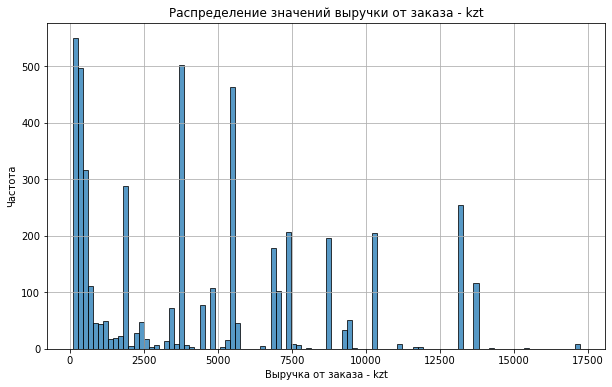

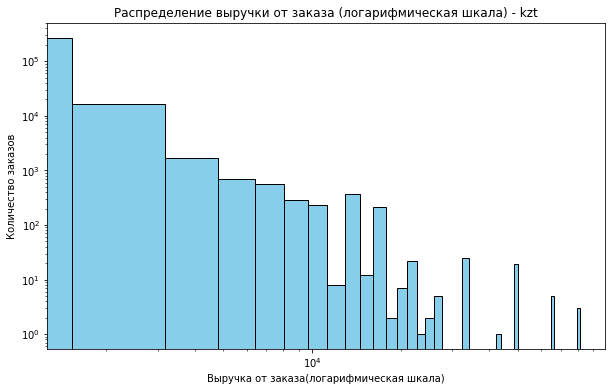

In [14]:
# Строим гистограмму распределения значений
df_quantile_kzt['revenue'].plot(
                kind='hist', # гистограмма
                bins=100, # количество корзин
                figsize=(10, 6),
                alpha=0.75,
                edgecolor='black')


# Настраиваем оформление графика
plt.title('Распределение значений выручки от заказа - kzt')
plt.xlabel('Выручка от заказа - kzt')
plt.ylabel('Частота')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()

# Строим гистограмму с логарифмической шкалой
plt.figure(figsize=(10, 6))
plt.hist(df_all['revenue'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.xscale('log')  # Логарифмическая шкала по оси X
plt.xlabel('Выручка от заказа(логарифмическая шкала)')
plt.ylabel('Количество заказов')
plt.title('Распределение выручки от заказа (логарифмическая шкала) - kzt')
plt.show()


In [15]:
# Уберём экстемальные выбросы из исходного датафрейма - 1% справа и слева колонки revenue для rub и kzt 
df = pd.concat([df_quantile_rub, df_quantile_kzt])

Выводы:
- Распределение данных характеризуется широким разбросом и длинным «хвостом» в правой части гистограммы. Такие высокие значения можно отнести к выбросам. Для дальнейшего анализа мы их исключаем.

#### 2.4 Проверим явные и неявные дубликаты по бронированию билета без учёта идентификаторов заказа

In [16]:

col_dupl = ['user_id',
 'created_dt_msk',
 'created_ts_msk',
 'event_id',
 'cinema_circuit',
 'age_limit',
 'currency_code',
 'device_type_canonical',
 'revenue',
 'service_name',
 'tickets_count',
 'total',
 'days_since_prev',
 'event_name',
 'event_type_description',
 'event_type_main',
 'organizers',
 'region_name',
 'city_name',
 'city_id',
 'venue_id',
 'venue_name',
 'venue_address']

# Отобразим первые 3 дублирующихся строки
print('Дублирующиеся строки:')
display(df[df.duplicated(subset=col_dupl)].head(3))
# Отобразим все колонки датафрейма
pd.set_option('display.max_columns', None)

print('Кол-во дубликатов без учёта идентификаторов заказа: \n- в исходном датасете')
print(df.duplicated(subset=col_dupl).sum())
 

# Удалим дубликаты
df_uniq = df.drop_duplicates(subset=col_dupl)

print('- после удаления дублей')
print(df_uniq.duplicated(subset=col_dupl).sum())

Дублирующиеся строки:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
3839,7299678,a0384c26d91e09e,2024-08-24,2024-08-24 00:07:14,534657,нет,16,rub,mobile,679.21,...,Ветренский регион,Кокжар,20,2866,"Школа фотографии ""Золотое"" Инк","ш. Микрорайон, д. 79 стр. 50",2024-08-24,100,19.1202,kzt
48973,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,Североярская область,Озёрск,2,2795,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482",2024-08-23,100,19.1903,kzt
48977,5373179,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,Североярская область,Озёрск,2,2795,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482",2024-08-23,100,19.1903,kzt


Кол-во дубликатов без учёта идентификаторов заказа: 
- в исходном датасете
29
- после удаления дублей
0


Вывод:
- при анализе  данных по бронированию билета без учёта идентификаторов заказа выявлено 29 дубликатов. По дате и времени создания видно, что заказазы были созданы одномоментно. Дублирование могло быть вызвано сбоем в сети при оформлении. Данные дубликаты были удалены.

#### 2.4 Проведите преобразования типов данных.    



- Обработаем типы данных в столбцах, которые хранят значения даты и времени

In [17]:
# Определим список полей с датой
column_date = ['created_dt_msk', 'created_ts_msk', 'data']

print('Исходный формат полей:')
print(df_uniq[column_date].dtypes)

# Приводим данные с датой и временем к типу datetime64[ns]
for column in column_date:
    df_uniq[column] = pd.to_datetime(df_uniq[column]) # df_uniq[column].astype('datetime64[ns]') 
    
# Проверим результат   
print('Формат после изменения типа:')
print(df_uniq[column_date].dtypes)


Исходный формат полей:
created_dt_msk    object
created_ts_msk    object
data              object
dtype: object
Формат после изменения типа:
created_dt_msk    datetime64[ns]
created_ts_msk    datetime64[ns]
data              datetime64[ns]
dtype: object


C:\Users\11961\AppData\Local\Temp\ipykernel_22048\345291691.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq[column] = pd.to_datetime(df_uniq[column]) # df_uniq[column].astype('datetime64[ns]')
C:\Users\11961\AppData\Local\Temp\ipykernel_22048\345291691.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq[column] = pd.to_datetime(df_uniq[column]) # df_uniq[column].astype('datetime64[ns]')
C:\Users\11961\AppData\Local\Temp\ipykernel_22048\345291691.py:9: SettingWithCopyWarning: 
A value is 

 - Уменьшим размерности количественных данных

In [18]:
# Оптимизируем целочисленный тип данных в датафрейме bank_df

column_int = ['order_id',
              'event_id',
              'age_limit',
              'tickets_count',
              'days_since_prev',
              'city_id',
              'venue_id',
              'nominal']
column_float = ['revenue',
                'total',
                'curs']
print('Исходные типы полей:')
print(df_uniq[column_int + column_float].dtypes)

for column in column_int:
    df_uniq[column] = pd.to_numeric(df_uniq[column],
                                    downcast='integer')
for column in column_float:
    df_uniq[column] = pd.to_numeric(df_uniq[column],
                                    downcast='float')
print()
# Проверим результат    
print('Преобразованные типы полей:')
print(df_uniq[column_int + column_float].dtypes)

C:\Users\11961\AppData\Local\Temp\ipykernel_22048\3147216808.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq[column] = pd.to_numeric(df_uniq[column],


Исходные типы полей:
order_id             int64
event_id             int64
age_limit            int64
tickets_count        int64
days_since_prev    float64
city_id              int64
venue_id             int64
nominal              int64
revenue            float64
total              float64
curs               float64
dtype: object

Преобразованные типы полей:
order_id             int32
event_id             int32
age_limit             int8
tickets_count         int8
days_since_prev    float64
city_id              int32
venue_id             int16
nominal               int8
revenue            float32
total              float32
curs               float32
dtype: object


C:\Users\11961\AppData\Local\Temp\ipykernel_22048\3147216808.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq[column] = pd.to_numeric(df_uniq[column],


#### 2.5 Создадим несколько новых столбцов  
- revenue_rub — выручка с заказа в единой валюте — российский рубль. 
- one_ticket_revenue_rub — рассчитаем выручку с продажи одного билета на мероприятие.  
- month — выделим месяц оформления заказа в отдельный столбец.
- season — создадим столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

In [19]:
# Добавим столбец revenue_rub — выручка с заказа в единой валюте — российский рубль.
df_uniq['revenue_rub'] = np.where(df_uniq['currency_code']=='kzt', df_uniq['revenue'] * df_uniq['curs'] / df_uniq['nominal'], df_uniq['revenue'])
# Добавим столбец one_ticket_revenue_rub — рассчитаем выручку с продажи одного билета на мероприятие.
df_uniq['one_ticket_revenue_rub'] = df_uniq['revenue_rub'] / df_uniq['tickets_count']
# Добавим столбец month — выделим месяц оформления заказа в отдельный столбец.
df_uniq['month'] = df_uniq['created_dt_msk'].dt.month

# Опреелим сезонность по условиям
conditions = [(df_uniq['month'] <= 2) | (df_uniq['month'] == 12),
              (df_uniq['month'] >= 3) & (df_uniq['month'] <= 5),
              (df_uniq['month'] >= 6) & (df_uniq['month'] <= 8),
              (df_uniq['month'] >= 9) & (df_uniq['month'] <= 11)]

choices = ['зима', 'весна', 'лето', 'осень']

# Добавим столбец season — с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'
df_uniq['season'] = np.select(conditions, choices)

# Проверим результат добавления колонок
display(df_uniq.head(3))

C:\Users\11961\AppData\Local\Temp\ipykernel_22048\320562231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq['revenue_rub'] = np.where(df_uniq['currency_code']=='kzt', df_uniq['revenue'] * df_uniq['curs'] / df_uniq['nominal'], df_uniq['revenue'])
C:\Users\11961\AppData\Local\Temp\ipykernel_22048\320562231.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq['one_ticket_revenue_rub'] = df_uniq['revenue_rub'] / df_uniq['tickets_count']
C:\Users\11961\AppData\Local\Temp\ipykernel_22048\320562

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,Край билетов,4,10870.990234,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.697201,kzt,1521.939941,380.484985,8,лето
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.420044,Край билетов,5,13588.740234,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.341900,kzt,1902.420044,380.484009,7,лето
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.449951,Край билетов,3,8153.250000,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-07-23,100,18.341900,kzt,1141.449951,380.483307,7,лето


In [20]:
# df_uniq.loc[(df_uniq['month'] <= 2) | (df_uniq['month'] == 12), 'season'] = 'зима'
# df_uniq.loc[(df_uniq['month'] >= 3) & (df_uniq['month'] <= 5), 'season'] = 'весна'
# df_uniq.loc[(df_uniq['month'] >= 6) & (df_uniq['month'] <= 8), 'season'] = 'лето'
# df_uniq.loc[(df_uniq['month'] >= 9) & (df_uniq['month'] <= 11), 'season'] = 'осень'

**Вывод:** 
- формат столбцов хранящих дату 'created_dt_msk', 'created_ts_msk', 'data', был измен с object на datetime 
- для оптимизации памяти уменьшена размерность столбцов содержащих количественных данные
- для дальнейшего анализа добавлены новые столбцы:
    - revenue_rub — выручка с заказа в единой валюте — российский рубль
    - one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие
    - month — месяц оформления заказа
    - season — сезонност, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'

### 3. Исследовательский анализ данных

### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения



----
- Для каждого месяца найдём количество заказов и визуализируем результаты. 

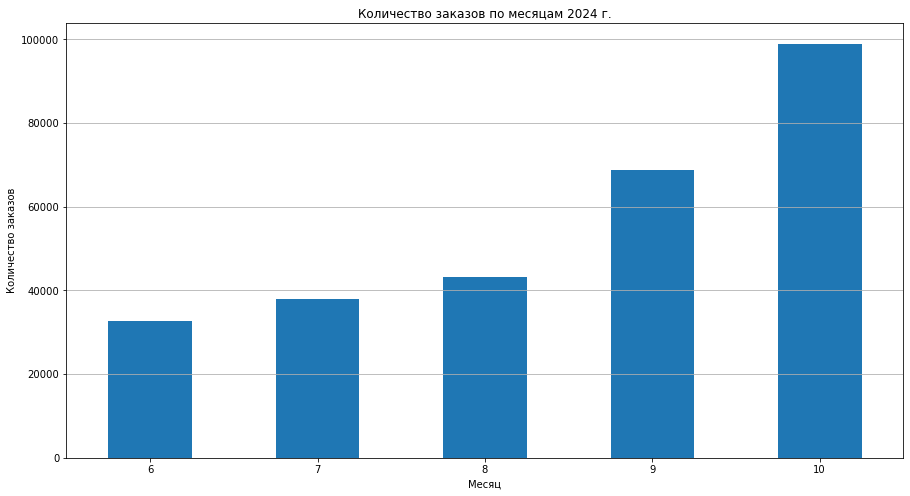

In [21]:
# Определим Количество заказов по месяцам
orders_count = df_uniq.groupby('month')['order_id'].count()

# Строим столбчатый график
orders_count.plot(
         kind='bar',
         figsize=(15, 8),
         rot = 0)

# Настраиваем оформление графика
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(axis='y')
plt.title('Количество заказов по месяцам 2024 г.')
# Выводим график
plt.show()

Вывод:
- отмечаем увеличение количества заказов от июня до ноября 2024 г.

----
  Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.

season,лето,осень
event_type_main,,
выставки,50.051986,49.948014
другое,46.585701,53.414299
концерты,44.269861,55.730139
спорт,12.818608,87.181392
стендап,47.825759,52.174241
театр,35.685028,64.314972
ёлки,13.900204,86.099796


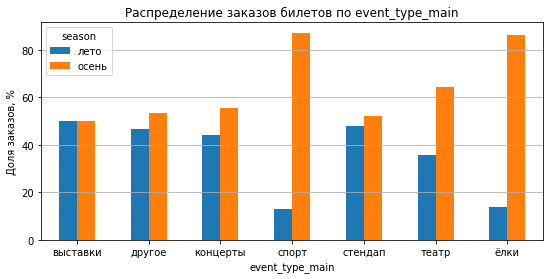

season,лето,осень
device_type_canonical,,
desktop,38.788323,61.211677
mobile,40.794203,59.205797


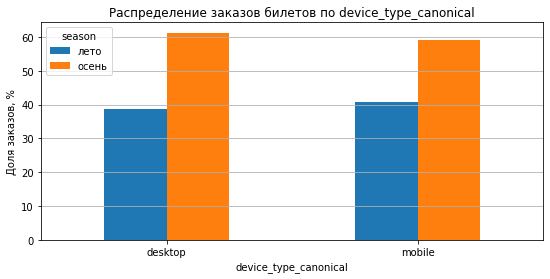

season,лето,осень
age_limit,,
0,34.464926,65.535074
6,41.331380,58.668620
12,39.235334,60.764666
16,42.291767,57.708233
18,47.415602,52.584398


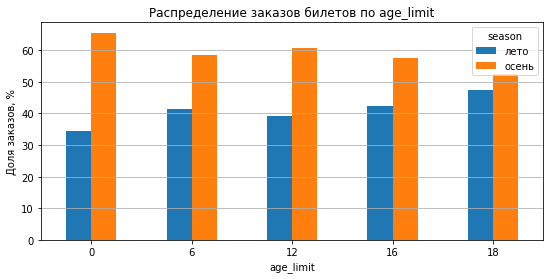

In [22]:
categories = ['event_type_main', 'device_type_canonical', 'age_limit']

for category in categories:
    
    # Определим количество заказов по сезонам
    orders_count = df_uniq.groupby([category, 'season'], as_index=False)['order_id'].count()

    # Добавляем столбец с расчетом доли
    orders_count['share'] = 100*orders_count['order_id']/orders_count.groupby(category)['order_id'].transform('sum')

    # Группируем кол-во заказов по категории
    orders_share = pd.pivot_table(orders_count, values='share', index=category,
                           columns=['season'], aggfunc="sum") 
    display(orders_share)
    
    # Строим столбчатый график
    orders_share.plot(kind='bar',
                          figsize=(9, 4),
                          rot=0
                          )
    # Настраиваем оформление графика
    plt.grid(axis='y')
    plt.xlabel(category)
    plt.ylabel('Доля заказов, %')
    plt.title(f'Распределение заказов билетов по {category}')
    # Отображаем график
    plt.show()

**Вывод:** 
- сравнительный анализ распределения заказов билетов по типу мероприятия показывает наибольше влияние сезонности на категории спорт,  ёлки где доля осенних заказов существенно выше летних и составляет около 90% от всех заказов, а так же театр с доле осенних заказов  64%. На категории выставки, другое, концерты и стендап влияние сезонности не существенно.
- распределения заказов билетов по типу устройства влияние сезонности лето/осень составляет 40/60 соответственно.
- сезонность не влияет на категорию 18 и старше при распределения заказов билетов. Для категории 16 и моложе доля осенних заказов выше летних и составляет от 57 до 65 %

----
Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.

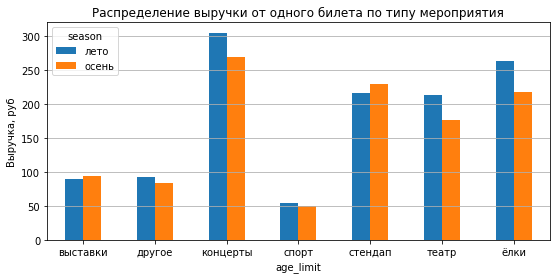

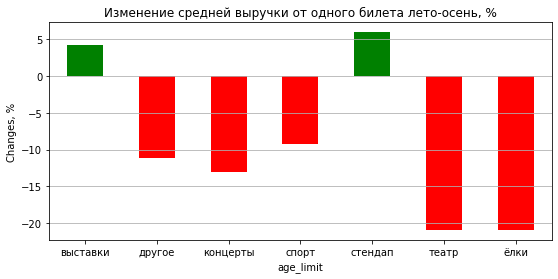

season,лето,осень,"changes,%"
event_type_main,,,
выставки,89.53,93.46,4.2
другое,92.65,83.36,-11.1
концерты,304.28,269.22,-13.0
спорт,54.69,50.09,-9.2
стендап,215.22,228.67,5.9
театр,213.44,176.47,-20.9
ёлки,263.50,217.97,-20.9


In [23]:
# Определим выручку с продажи одного билета в зависимости от типа мероприятия по сезонам
revenue_gr = df_uniq.groupby(['event_type_main', 'season'], as_index=False)\
                            .agg(revenue_sum = ('revenue_rub', 'sum'), ticket_sum = ('tickets_count', 'sum'))

# Добавляем столбец с расчетом средней выручки с билета
revenue_gr['ticket_revenue'] = round(revenue_gr['revenue_sum']/revenue_gr['ticket_sum'], 2)

# Группируем кол-во заказов по категории
revenue_ticket = pd.pivot_table(revenue_gr, values='ticket_revenue', index='event_type_main',
                           columns=['season'], aggfunc="sum") 

# Строим столбчатый график
revenue_ticket.plot(kind='bar',
                      figsize=(9, 4),
                      rot=0
                      ) 
# Настраиваем оформление графика
plt.grid(axis='y')
plt.xlabel(category)
plt.ylabel('Выручка, руб')
plt.title(f'Распределение выручки от одного билета по типу мероприятия')
# Отображаем график
plt.show()

# Добавим колонку с расчетом относительного изменения осенних значений по сравнению с летними
revenue_ticket['changes,%'] = round(100*(revenue_ticket['осень'] - revenue_ticket['лето'])/revenue_ticket['осень'], 1)
# Оставляем необходимые для графика столбцы
revenue_ticket_gr = revenue_ticket.groupby('event_type_main')['changes,%'].sum() #.agg(changes =('changes,%', 'sum')).reset_index()

# Строим столбчатый график

colors = ['green' if x >= 0 else 'red' for x in revenue_ticket_gr]
revenue_ticket_gr.plot(kind='bar',
                      figsize=(9, 4),
                      color=colors,
                      rot=0
                      ) 
# Настраиваем оформление графика
plt.grid(axis='y')
plt.xlabel(category)
plt.ylabel('Changes, %')
plt.title('Изменение средней выручки от одного билета лето-осень, %')
# Отображаем график
plt.show()
display(revenue_ticket)

Вывод:
- с наступлением осени увеличение средней выручки с одного билета происходит только в категориях выставки(3.7%) и стендап(8.7%). В остальных котегориях она снижается от -4% до -20%. Больле всего это относится к категориям театр(-19.7%) и ёлки(20.4%)

####  3.2. Осенняя активность пользователей

---
- Проанализируем динамику изменений по дням:
    - общего числа заказов;
    - количества активных пользователей DAU;
    - среднего числа заказов на одного пользователя;
    - средней стоимости одного билета.

In [25]:
df_autumn = df_uniq[df_uniq.season=='осень']

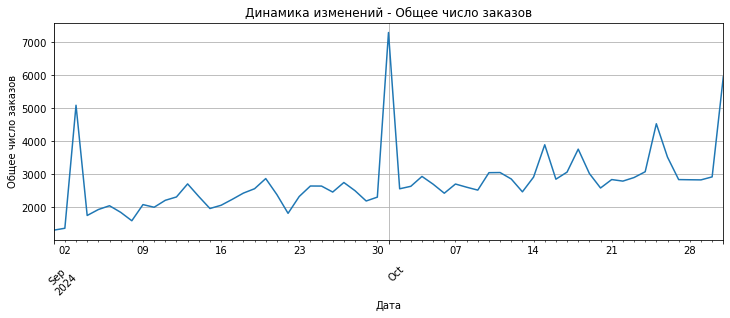

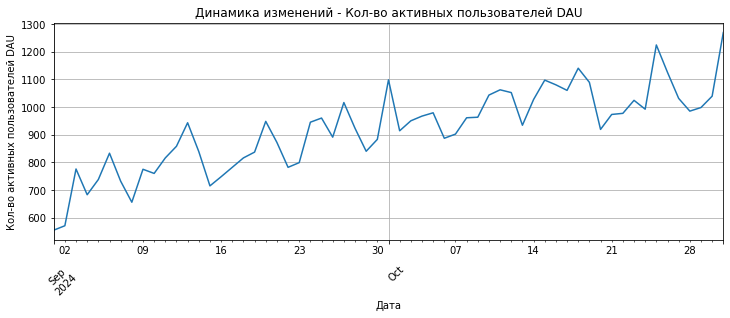

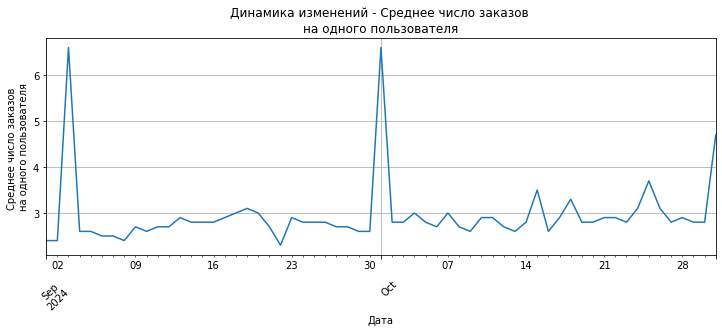

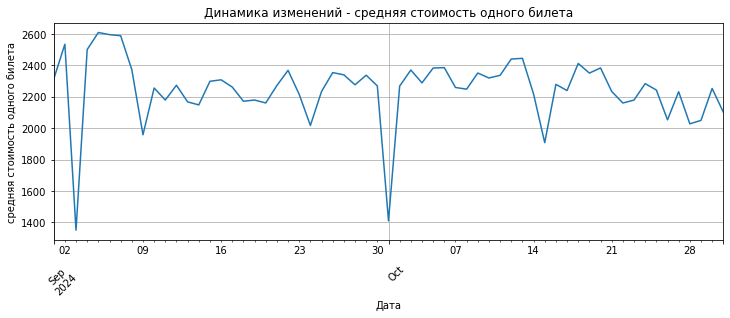

In [26]:
# Рассчитаем по дням число заказов и число уникальных пользователей
df_pt = pd.pivot_table(df_autumn, 
                       values=['order_id', 'user_id', 'total'], 
                       index='created_dt_msk',
                       aggfunc={'order_id':'count', # Общее число заказо
                                'user_id': lambda x: x.value_counts().count(), # Кол-во активных пользователей DAU
                                'total': lambda x:  x.sum()/df_autumn.loc[x.index, 'tickets_count'].sum() # средняя стоимость одного билета
                               }) 

# Добавим колонку с количеством заказов на одного пользователя
df_pt['orders_for_user'] = round(df_pt['order_id']/df_pt['user_id'], 1)
# print(df_pt)

# Определим категории данных для анализа
category = {'order_id':'Общее число заказов', 
            'user_id':'Кол-во активных пользователей DAU', 
            'orders_for_user':'Среднее число заказов \nна одного пользователя',
            'total': 'средняя стоимость одного билета'}
for i in category:
    # Строим линейный график
    df_pt[i].plot(figsize=(12, 4), # размер графика
                     ylabel=category[i])
    plt.xticks(rotation=45)

    # Настраиваем оформление графика
    plt.grid()
    plt.xlabel('Дата')
    plt.title(f'Динамика изменений - {category[i]}')
    # Выводим график
    plt.show()

Вывод:
- динамика показывает рост числа заказов и количества активных пользователей. Среднее число заказов на одного пользователя в течение месяца сохраняется с тенденцией к небольшому росту. Так же там наблюдаем два пика начала сентября и начала октября связанных с меньшей ценой билета. 

----
Изучим недельную цикличность. Сравним пользовательскую активность в будни и выходные.

C:\Users\11961\AppData\Local\Temp\ipykernel_22048\3531183238.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq['week_day'] = df_uniq['created_dt_msk'].dt.dayofweek


,user_id
week_day,
0,6491
1,7042
2,6980
3,7131
4,7198
5,6990
6,6298


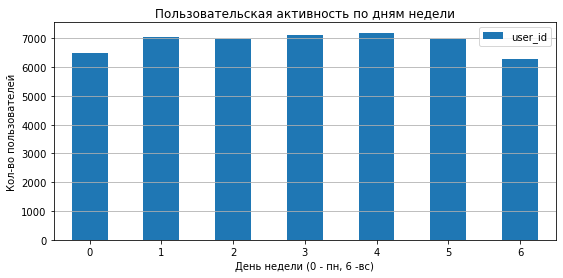

In [27]:
# Добавим колонку с номером дня недели
df_uniq['week_day'] = df_uniq['created_dt_msk'].dt.dayofweek

# Сгруппируем по дню недели и кол-ву уникальных пользователей
df_weekday = pd.pivot_table(df_uniq, 
                       values=['user_id'], 
                       index='week_day',
                       aggfunc={'user_id': lambda x: x.value_counts().count()})
display(df_weekday)

# Строим столбчатый график
df_weekday.plot(kind='bar',
                      figsize=(9, 4),
                      rot=0
                      ) 
# Настраиваем оформление графика
plt.grid(axis='y')
plt.xlabel(category)
plt.ylabel('Кол-во пользователей')
plt.xlabel('День недели (0 - пн, 6 -вс)')
plt.title('Пользовательская активность по дням недели')

# Отображаем график
plt.show()


Вывод?
- наибольшая активность пользователей наблюдается в четверг с пиком в пятницу. Наименьшая активность в понедельник и воскресение. Но также при анализе результатов необходимо учесть, что в течение периода количество календарных и фактических выходных и будних дней может отличаться.

#### 3.3. Популярные события и партнёры

----
Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов.

,region_name,order_count,event_count,"event_share,%","order_share,%"
23,Каменевский регион,85398,5792,26.3,30.3
60,Североярская область,43591,3777,17.2,15.5
77,Широковская область,16087,1217,5.5,5.7
57,Светополянский округ,7464,1059,4.8,2.7
52,Речиновская область,6266,701,3.2,2.2
74,Травяная область,4719,667,3.0,1.7
11,Горицветская область,5153,551,2.5,1.8
61,Серебринская область,5586,541,2.5,2.0
78,Яблоневская область,6120,534,2.4,2.2
69,Тепляковская область,4384,528,2.4,1.6


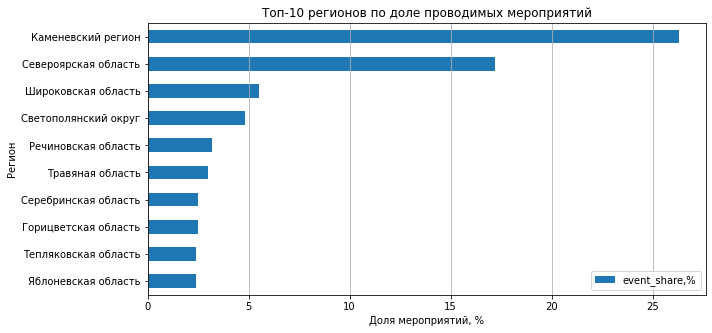

In [28]:
# Расчитаем уникальное количество мероприятий и общее число заказов
events_gr = df_uniq.groupby(['region_name'], as_index=False)\
                            .agg(order_count = ('order_id', 'count'), 
                                 event_count = ('event_id', lambda x: x.value_counts().count()))\
                            .sort_values(by='event_count',ascending=False)
# Добавляем столбец с расчетом доли кол-ва мероприятий региона
events_gr['event_share,%'] = round(100*events_gr['event_count']/events_gr['event_count'].sum(), 1)
# Добавляем столбец с расчетом доли кол-ва заказов региона
events_gr['order_share,%'] = round(100*events_gr['order_count']/events_gr['order_count'].sum(), 1)

display(events_gr.head(10))

# Строим столбчатую диаграмму
events_gr.head(10).sort_values('event_share,%').plot(x = 'region_name',
               y = 'event_share,%',
               kind = 'barh', # тип графика 
               rot = 0, # градус вращения подписи по оси Х
               figsize=(10, 5),
               title = f'Топ-10 регионов по доле проводимых мероприятий'
                            )
# Настраиваем оформление графика
plt.xlabel('Доля мероприятий, %')
plt.ylabel('Регион') 
plt.grid(axis='x') # добавляем сетку графика

# Выводим график
plt.show()

Вывод:
- Ключевыми регионами по количеству проводимых мероприятий являются Каменевский регион с долей 26.7% и Североярская область 17%. Остальные регионы имеют долю от 5% и ниже

---
Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.

,service_name,order_count,event_count,revenue_sum,"event_share,%","order_share,%","revenue_share,%"
24,Мой билет,34198,1296,35935232.0,5.4,12.1,21.700001
3,Билеты без проблем,57819,4018,26427948.0,16.7,20.5,16.000000
25,Облачко,26402,2335,18588614.0,9.7,9.4,11.200000
21,Лови билет!,40503,4813,16670375.0,20.0,14.4,10.100000
8,Весь в билетах,16410,855,16494669.0,3.6,5.8,10.000000
5,Билеты в руки,39803,3486,13194799.0,14.5,14.1,8.000000
19,Край билетов,6109,252,6405689.0,1.0,2.2,3.900000
26,Прачечная,10222,1026,4746810.5,4.3,3.6,2.900000
13,Дом культуры,4412,272,4358656.0,1.1,1.6,2.600000
35,Яблоко,5004,714,3868337.0,3.0,1.8,2.300000


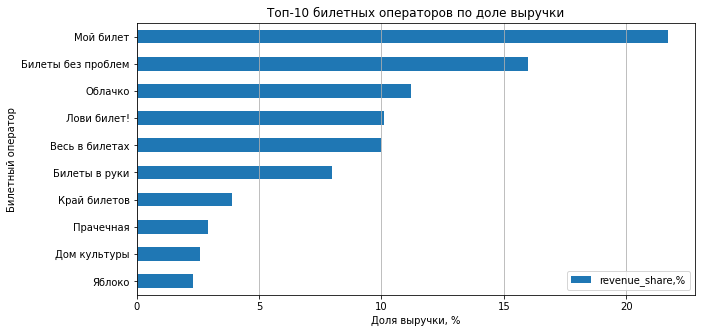

In [29]:
# Расчитаем уникальное количество мероприятий и общее число заказов
partners_gr = df_uniq.groupby(['service_name'], as_index=False)\
                            .agg(order_count = ('order_id', 'count'), 
                                 event_count = ('event_id', lambda x: x.value_counts().count()),
                                 revenue_sum = ('revenue', 'sum'))\
                            .sort_values(by='revenue_sum',ascending=False)
# Добавляем столбец с расчетом доли кол-ва мероприятий от партнера
partners_gr['event_share,%'] = round(100*partners_gr['event_count']/partners_gr['event_count'].sum(), 1)
# Добавляем столбец с расчетом доли кол-ва заказов от партнера
partners_gr['order_share,%'] = round(100*partners_gr['order_count']/partners_gr['order_count'].sum(), 1)
# Добавляем столбец с расчетом доли выручки от партнера
partners_gr['revenue_share,%'] = round(100*partners_gr['revenue_sum']/partners_gr['revenue_sum'].sum(), 1)

display(partners_gr.head(10))

# Строим столбчатую диаграмму
partners_gr.head(10).sort_values('revenue_share,%').plot(x = 'service_name',
               y = 'revenue_share,%',
               kind = 'barh', # тип графика 
               rot = 0, # градус вращения подписи по оси Х
               figsize=(10, 5),
               title = f'Топ-10 билетных операторов по доле выручки'
                            )
# Настраиваем оформление графика
plt.xlabel('Доля выручки, %')
plt.ylabel('Билетный оператор') 
plt.grid(axis='x') # добавляем сетку графика

# Выводим график
plt.show()

**Вывод:** Явными лидерами среди билетных операторов являются Мой билет	с долей выручке 22.7% и Билеты без проблем 15.9%. 6 из 36 партнеров-лидеров совокупно приносят около 80% всей выручки. Остальные менее 2-3%

### 4. Статистический анализ данных

##### 4.1 Проверяем следующие гипотизы:  
- H₀ (нулевая гипотеза) — среднее количество заказов на одного пользователя мобильного приложения не отличается от пользователя стационарных устройств.
- H₁ (альтернативная гипотеза) — среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
---
- Для сравнения средних значений двух выборок наиболее подходит тест Уэлча ttest_ind. T-тест Уэлча не требует равенства дисперсий и применим даже при статистически разных дисперсиях.

In [30]:
# Определим размер групп для определения типа необходимого теста
mob_gr_count = df_autumn[df_autumn['device_type_canonical']=='mobile']['user_id'].nunique()
pc_gr_count = df_autumn[df_autumn['device_type_canonical']=='desktop']['user_id'].nunique()

# Расчитаем долю уникальных пользователей по типу устройства
mob_share = round(100*mob_gr_count/(mob_gr_count+pc_gr_count))
print(f'Доля уникальных пользователей мобильного приложения: {mob_share} %')

pc_share = round(100*pc_gr_count/(mob_gr_count+pc_gr_count))
print(f'Доля уникальных пользователей стационарных устройств: {pc_share} %')

diff = abs(mob_share - pc_share)
print(f'Разница между двумя группами {diff} %')

Доля уникальных пользователей мобильного приложения: 74 %
Доля уникальных пользователей стационарных устройств: 26 %
Разница между двумя группами 48 %


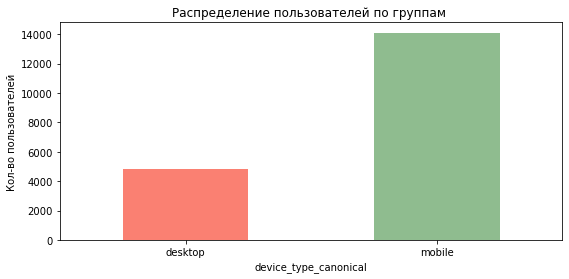

In [31]:
df_ = df_autumn.groupby('device_type_canonical')['user_id'].nunique()

# Строим диаграмму распределения пользователей по группам пользователей
df_.plot(kind='bar',
                  rot=0,
                  color=['salmon', 'darkseagreen'],
                  figsize=(9, 4))#labels=('Группа А', 'Группа В')
            
# Настраиваем оформление графика
plt.title("Распределение пользователей по группам ")
plt.ylabel('Кол-во пользователей')
# Отображаем график
plt.show() 

Вывод:
- распределение кол-ва пользователей не равномерно. Разницу количества между двух групп менее 48% является существенной существенной

In [32]:
# Пользователи группы А
mob_gr = df_autumn[df_autumn['device_type_canonical']=='mobile']['user_id']
# Пользователи группы В
pc_gr = df_autumn[df_autumn['device_type_canonical']=='desktop']['user_id']

# Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B
interselection = len(list(set(mob_gr) & set(pc_gr)))
print(f'Кол-во пользователей, которые встречаются одновременно в группах A и B: {interselection}')

Кол-во пользователей, которые встречаются одновременно в группах A и B: 3234


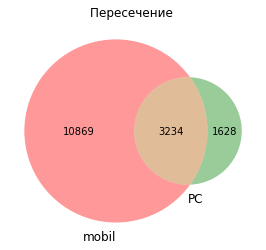

In [33]:
A = set(mob_gr.unique())
B = set(pc_gr.unique())

# Строим диаграмму Венна
venn2([A, B], set_labels=('mobil', 'PC'))

# Отображаем график
plt.title("Пересечение ")
plt.show() 


Вывод:
- диаграмма Венна показывает наличие пересечений двух групп между собой, т.е. пользователи одной группы попадают в другую

In [34]:
# Определим уникальные user_id попавшие в пересечение обоих групп пользователей
cross = set(mob_gr) & set(pc_gr)

# Отсечём пользователей попавшие в обе группы
df_no_cross = df_autumn[~df_autumn['user_id'].isin(cross)]

In [35]:
# Определим среднее количество заказов на одного пользователя мобильного приложения
mob_user_test_1 = df_no_cross[df_no_cross['device_type_canonical']=='mobile'].groupby('user_id')['order_id'].count()
# Определим среднее количество заказов на одного пользователя стационарных устройств
pc_user_test_1 = df_no_cross[df_no_cross['device_type_canonical']=='desktop'].groupby('user_id')['order_id'].count()

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    mob_user_test_1, 
    pc_user_test_1,
    equal_var=False,
    alternative='greater' ) 

if p_value_ttest>alpha:
    print(f'Полученное значение теста Уэлча p_value={round(p_value_ttest, 5)} больше критического уровня alpha={alpha} Опровергнуть нулевую гипотезу нельзя.')
    print('H₀ (нулевая гипотеза) — среднее количество заказов на одного пользователя мобильного приложения не отличается от пользователя стационарных устройств')
else:
    print(f'Полученное значение теста Уэлча p_value={round(p_value_ttest, 5)} меньше критического уровня alpha={alpha} Принимаем альтернативную гипотезу.')    
    print('H₁ (альтернативная гипотеза) — среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.')

Полученное значение теста Уэлча p_value=0.0 меньше критического уровня alpha=0.05 Принимаем альтернативную гипотезу.
H₁ (альтернативная гипотеза) — среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.


##### 4.2   Проверяем следующие гипотизы:  
- H₀ (нулевая гипотеза) — Среднее время между заказами пользователей мобильных приложений не отличается от времени пользователей стационарных устройств.
- H₁ (альтернативная гипотеза) — Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.
---
Для сравнения средних значений двух выборок наиболее подходит тест Уэлча ttest_ind. T-тест Уэлча не требует равенства дисперсий и применим даже при статистически разных дисперсиях.

In [36]:
# Определим среднее время между заказами пользователей мобильных приложений
mob_user_test_2 = df_no_cross.loc[(df_no_cross['device_type_canonical']=='mobile') & (df_uniq['days_since_prev']>0)]['days_since_prev']
# Определим среднее время между заказами пользователей стационарных устройств
pc_user_test_2 = df_no_cross.loc[(df_no_cross['device_type_canonical']=='desktop') & (df_uniq['days_since_prev']>0)]['days_since_prev']

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    mob_user_test_2, 
    pc_user_test_2, 
    equal_var=False,
    alternative='greater' ) 

if p_value_ttest>alpha:
    print(f'Полученное значение теста Уэлча p_value={round(p_value_ttest, 5)} больше критического уровня alpha={alpha} Опровергнуть нулевую гипотезу нельзя.')
    print('H₀ (нулевая гипотеза) — среднее время между заказами пользователей мобильных приложений не отличается от времени пользователей стационарных устройств.')
else:
    print(f'Полученное значение теста Уэлча p_value={round(p_value_ttest, 5)} меньше критического уровня alpha={alpha} Принимаем альтернативную гипотезу.')    
    print('H₁ (альтернативная гипотеза) — среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.')

Полученное значение теста Уэлча p_value=1.0 больше критического уровня alpha=0.05 Опровергнуть нулевую гипотезу нельзя.
H₀ (нулевая гипотеза) — среднее время между заказами пользователей мобильных приложений не отличается от времени пользователей стационарных устройств.


 ### 5. Общий вывод и рекомендации

Общий обзор проделанной работы. В ходе исследования были проанализированы данные сервиса Яндекс Афиша за период июнь-октябрь 2024.
- Первичноый анализ полноты данных показывает, что данные достаточно высокого качества. Наличие 29 неявных дубликатов и пропущенные 7.5% данных в колонке с количеством дней с предыдущей покупки не являются существенными. Полнона и корректность данных достаточна для анализа.
- Популярность мерооприятий осенью растёт хотя и наблюдается небольшое снижение средней выручки. Наибольше влияние сезонности на категории спорт, ёлки где доля осенних заказов существенно выше летних и составляет около 90% от всех заказов, а так же театр с доле осенних заказов 64%. На категории выставки, другое, концерты и стендап влияние сезонности не существенно. С наступлением осени увеличение средней выручки с одного билета происходит только в категориях выставки(3.7%) и стендап(8.7%). В остальных котегориях она снижается от -4% до -20%. Больле всего это относится к категориям театр(-19.7%) и ёлки(20.4%)  
- Динамика показывает рост количества активных пользователей и числа заказов. Если в летние месяцы тренд роста незначительный, то с наступлением осени наблюдаем существенное повышение динамики роста. Так же наблюдаем два пика начала сентября и начала октября.
- Сезонность не влияет на категорию 18 и старше при распределения заказов билетов. Для категории 16 и моложе доля осенних заказов выше летних и составляет от 57 до 65 %
- Наибольшая активность пользователей наблюдается в четверг с пиком в пятницу. Наименьшая активность в понедельник и воскресение 
- Ключевыми регионами по количеству проводимых мероприятий являются Каменевский регион с долей 26.7% и Североярская область 17%. Остальные регионы имеют долю от 5% и ниже
- Явными лидерами среди билетных операторов являются Мой билет с долей выручке 22.7% и Билеты без проблем 15.9%. 6 из 36 партнеров-лидеров совокупно приносят около 80% всей выручки. Остальные менее 2-3%
- В результа стат анализа подтвердилась гипотеза, что среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств
- Также было выяснено, что среднее время между заказами пользователей мобильных приложений не отличается от времени пользователей стационарных устройств.

На основе исследования можно было увидеть, что с наступлением осени увеличилось количество заказов, однако у средней стоимости был тренд к снижению. Одна из причин - существенное увеличения осенью мероприятий для возростной группы 16 лет и моложе с более низкой ценой билета, а так же спортивных мероприятий. Также с окончание отпускного периода происходит оживление интереса пользователей к проведению досуга. В свою очередь, компании предлагающие услуги идут на снижение цен с целью привлечения большего числа пользователей на свои мероприятия.

Рекомендации: Уделить больше внимание и развивать мобильные сервисы как наиболее перспективные и удобные для предложения услуг с акцентом на молодежную аудиторию. 